# Regression models for College Football Game Prediction

The goal is to predict the outcomes of college football games. Most notably, we are interested in a prediction of the final score for a given football game. There is a related and potentially intermediary step along this pathway which involves predicting the stats in a game aside from score. To generate predictions for all of the above, we break up the problem into two steps. First, we use historical statistics for each team in a given game to predict their stats in the next game. This is what we refer to as "Model 1". Then, we use the (predicted) statistics for each team in a given game to predict the score. This is what we refer to as "Model 2". In this pipeline, we would predict the final score of a game by first applying Model 1 to historical data and then applying Model 2 with input the output given by Model 1.

We also develop a model which skips the statistical predictions, instead directly going from historical data to a score, this is what we refer to as "Model 3". 

In this notebook, we will look at regression-based approaches for each of the models presented above. In the notebook "Prediction with Deep Learning Models", we will look at models performing similar functions utilizing a deep learning neural network framework.


## Model 1
In this model, we start with input the recent historical stats of each teams in a game and predict the stats for both teams in their pending matchup. 

In [27]:
# Import the necessary libraries
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
from sklearn.linear_model import MultiTaskLassoCV, MultiTaskElasticNetCV, RidgeCV, ElasticNet, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


### Data input and processing into train and test data

In [3]:
# Read in the dataframe of the stats for a given team in a given game
games_df = pd.read_csv("clean_games_with_opp.csv", index_col=0)
games_df.reset_index(drop=True, inplace=True)
games_df.head()

,school,school_id,points,fumblesRecovered,rushingTDs,passingTDs,kickReturnYards,kickReturnTDs,kickReturns,kickingPoints,...,opposing_rushingTDs,opposing_points,side,thirdDownConverts,thirdDownAttempts,fourthDownConverts,fourthDownAttempts,completions,passAttempts,passCompletionPercentage
0,Navy,2426,17,0.0,2.0,0.0,64.0,0.0,4.0,5.0,...,1.0,34,A,4.0,12.0,1.0,1.0,2.0,4.0,0.500000
1,UAB,5,48,1.0,4.0,2.0,64.0,0.0,2.0,12.0,...,1.0,10,A,9.0,14.0,0.0,0.0,13.0,20.0,0.650000
2,UMass,113,7,0.0,0.0,1.0,95.0,0.0,4.0,1.0,...,2.0,30,A,3.0,11.0,1.0,1.0,9.0,22.0,0.409091
3,UCF,2116,24,1.0,2.0,1.0,142.0,0.0,5.0,6.0,...,1.0,26,A,5.0,13.0,2.0,2.0,12.0,22.0,0.545455
4,Houston,248,7,1.0,1.0,0.0,89.0,0.0,6.0,1.0,...,3.0,27,A,4.0,16.0,4.0,4.0,25.0,50.0,0.500000


In [4]:
# Drop all columns with more than 25 nulls, then drop the individual rows that have nulls
x = games_df.isna().sum().to_dict()
column_drop = []

for k, v in x.items():
    if v > 25 :
        column_drop.append(k)

# Additionally, drop columns with irregular formats or which are already covered by other variables 
extend_list = ['completionAttempts','totalPenaltiesYards','possessionTime','possession_minutes','possession_seconds','year','week','school','opposing_points']
column_drop = column_drop + extend_list
games_df.drop(columns=column_drop, inplace = True)
games_df.dropna(axis = 0, inplace = True)
games_df = games_df.select_dtypes(exclude=["object"])

# Sort the rows so that the the two rows corresponding to a single game are adjacent
games_df = games_df.sort_values("id")

When looking at how much historical data to remember, we set this value, which we call "memory" to 12 games. This choice is made as 12 games is roughly is roughly the past seasons-worth of games for an average team. 

In [5]:
memory = 12

Now we setup the data for the inputs (X) and outputs (y) of our model. In initial attemps at modelling, we attempted to predict teams stats based on historical data on a per-team basis. We found this didn't perform very well as it didn't take into account the pending opponent. In the approach we use below, we combine the recent statistics for *both* teams to predict *both* teams statistics in their upcoming game simultaneously.

In [7]:
# Gather a dictionary of the deams and all of their games, sorted chronologically 
teams = set(games_df["school_id"])
teams_dict = {}

for team in teams:
    temp_df = games_df[games_df["school_id"] == team].sort_values("id")
    teams_dict[team] = temp_df.reset_index(drop=True)

In [33]:
X = []
y = []
points = []

# Loop over all of the teams that have played games
for team in teams:
    # Get the list of games that team has played in
    team1_df = teams_dict[team]
    
    # Loop over all possible games for a the team when there have been enough historical games
    for i in range(memory, len(team1_df)):
        # Find the two teams participating in the game
        game_id = team1_df.loc[i]["id"]
        both_teams_ids = games_df[games_df["id"] == game_id]["school_id"]
        both_teams_ids = list(both_teams_ids)

        # Throw out some odd cases where there was only data for one of the teams in a given game
        if len(both_teams_ids) != 2:
            continue
 
        # Extract the dataframes for the two teams, find the index of the game it was for them
        t1_df = teams_dict[both_teams_ids[0]]
        t2_df = teams_dict[both_teams_ids[1]]

        t1_gamen = np.where(t1_df["id"] == game_id)[0][0]
        t2_gamen = np.where(t2_df["id"] == game_id)[0][0]

        # Check to make sure that both teams have enough historical games in the past
        if t1_gamen < memory or t2_gamen < memory:
            continue
        
        # Extract the games in recent history, dropping columns that don't go into the data
        t1_df = t1_df.loc[t1_gamen-memory:t1_gamen]
        t2_df = t2_df.loc[t2_gamen-memory:t2_gamen]
        
        # Save the points into an array for use in the training and testing of Model 2
        points.append([np.array(t1_df["points"])[-1], np.array(t2_df["points"])[-1]])
        t1_df.drop(columns=["id", "school_id", "points"], inplace=True)
        t2_df.drop(columns=["id", "school_id", "points"], inplace=True)

        t1_array = np.array(t1_df)
        t2_array = np.array(t2_df)

        # Break the arrays into historical games and current game to go into training and test set
        t1_past = t1_array[0:-1]
        t1_present = t1_array[-1]
        t2_past = t2_array[0:-1]
        t2_present = t2_array[-1]

        # Add the data to the training and test set
        X.append(np.hstack([t1_past, t2_past]))
        y.append(np.hstack([t1_present, t2_present]))

We now have as the input to the model for a single input-output consisting of a memory-by-(number of stats) array, with an output a (number of stats) array. Since the data is going into a regression model, we need to flatten the input.

In [34]:
X_flat = []
for i in range(len(X)):
    X_flat.append(X[i].reshape(-1))

X = np.array(X_flat)
y = np.array(y)

print(f"Size of one input is {X.shape[1]} and size of one output is {y.shape[1]}")

Size of one input is 672 and size of one output is 56


Now we scale the data, split it into train and test sets, and then train and test various models.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale the input
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scale the output. Note for regression this is not required to train the model propertly, but we use it for analyzing results
scaler2 = StandardScaler()
scaler2.fit(y_train)
y_train_scaled = scaler2.transform(y_train)
y_test_scaled = scaler2.transform(y_test)

### Training the Regression Models and Result Analysis
We will use ridge, elastic net, and lasso regression with scikit-learn's built-in cross-validation:

In [36]:
ridgeCV = RidgeCV()
ela = ElasticNet()
lasso = Lasso()

In turn, we fit the models and make predictions:

In [37]:
ridgeCV.fit(X_train_scaled, y_train_scaled)

y_ridgepred = ridgeCV.predict(X_test_scaled)
print(f"Ridge CV MSE is {mean_squared_error(y_test_scaled, y_ridgepred)}")


Ridge CV MSE is 0.8553725798627393


In [45]:
lasso = MultiTaskLassoCV(alphas=[0.01, 0.1, 1, 10], cv=5)

lasso.fit(X_train_scaled, y_train_scaled)

y_lassopred = lasso.predict(X_test_scaled)
print(f"Lasso MSE is {mean_squared_error(y_test_scaled, y_lassopred)}")

Lasso MSE is 0.8420723482244201


In [46]:
elaCV = MultiTaskElasticNetCV(alphas=[0.01, 0.1, 1, 10], cv=5)

elaCV.fit(X_train_scaled, y_train_scaled)

y_elapred = elaCV.predict(X_test_scaled)
print(f"Elastic Net MSE is {mean_squared_error(y_test_scaled, y_elapred)}")

Elastic Net MSE is 0.8401624317505083


Add in some commentary here

## Model 2
Recall that in Model 2, we take as input the stats for a given game and predict the output of the game.

In [49]:
# Importing modules
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, LassoCV, MultiTaskLassoCV, MultiTaskElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


Load in the data fresh to regain some features we deleted whilst studying Model 1.

In [95]:
clean_games_df = pd.DataFrame(data = pd.read_csv('clean_games_with_opp.csv', index_col=0))
clean_games_df.reset_index(drop=True, inplace=True)
clean_games_df.head()

,school,school_id,points,fumblesRecovered,rushingTDs,passingTDs,kickReturnYards,kickReturnTDs,kickReturns,kickingPoints,...,opposing_rushingTDs,opposing_points,side,thirdDownConverts,thirdDownAttempts,fourthDownConverts,fourthDownAttempts,completions,passAttempts,passCompletionPercentage
0,Navy,2426,17,0.0,2.0,0.0,64.0,0.0,4.0,5.0,...,1.0,34,A,4.0,12.0,1.0,1.0,2.0,4.0,0.500000
1,UAB,5,48,1.0,4.0,2.0,64.0,0.0,2.0,12.0,...,1.0,10,A,9.0,14.0,0.0,0.0,13.0,20.0,0.650000
2,UMass,113,7,0.0,0.0,1.0,95.0,0.0,4.0,1.0,...,2.0,30,A,3.0,11.0,1.0,1.0,9.0,22.0,0.409091
3,UCF,2116,24,1.0,2.0,1.0,142.0,0.0,5.0,6.0,...,1.0,26,A,5.0,13.0,2.0,2.0,12.0,22.0,0.545455
4,Houston,248,7,1.0,1.0,0.0,89.0,0.0,6.0,1.0,...,3.0,27,A,4.0,16.0,4.0,4.0,25.0,50.0,0.500000


Again do some basic processing to throw out missing/bad data.

In [96]:

# Dropping all columns with more than 25 nulls, then dropping the individual rows that have nulls
x = clean_games_df.isna().sum().to_dict()
column_drop = []

for k, v in x.items():
    if v > 25 :
        column_drop.append(k)

# Additionally, these columns are weird formats or already covered by other variables (ie the possession stuff)
extend_list = ('rushingTDs', 'passingTDs', 'opposing_rushingTDs', 'opposing_passingTDs', 'completionAttempts','totalPenaltiesYards','possessionTime','possession_minutes','possession_seconds','year','week','school','school_id')

column_drop.extend(extend_list)

clean_games_df.drop(columns=column_drop, inplace = True)
clean_games_df.dropna(axis = 0, inplace = True)


Set up a manual train-test split on the games themselves.

In [102]:
train_density = 0.75
games_ids = set(clean_games_df["id"])
train_ids = random.sample(list(games_ids), int(train_density*len(games_ids)))
test_ids = list(games_ids - set(train_ids))

test_games_df = clean_games_df[clean_games_df["id"].isin(test_ids)]
train_games_df = clean_games_df[clean_games_df["id"].isin(train_ids)]

Some of the games didn't have the same level of data for the home and away teams, so we removed said games.

In [104]:
# All the home IDs
home_ids = train_games_df.loc[train_games_df.side == 'H'].id.values
# All the away IDs
away_ids = train_games_df.loc[train_games_df.side == 'A'].id.values

# IDs missing home values
missing_home = set(away_ids) - set(home_ids)
if not missing_home:
    missing_home = set(home_ids) - set(away_ids)
    
for id in missing_home:
    train_games_df.drop(train_games_df.loc[train_games_df['id'] == id].index, inplace=True)
    train_ids.remove(id)

# Check to see number of home and away games match
print(train_games_df.side.value_counts()['A']
,train_games_df.side.value_counts()['H'], len(train_ids))
pd.options.mode.chained_assignment = None 

# Repeat with test games
# All the home IDs
home_ids = test_games_df.loc[test_games_df.side == 'H'].id.values
# All the away IDs
away_ids = test_games_df.loc[test_games_df.side == 'A'].id.values

# IDs missing home values
missing_home = set(away_ids) - set(home_ids)

for id in missing_home:
    test_games_df.drop(test_games_df.loc[test_games_df['id'] == id].index, inplace=True)
    test_ids.remove(id)

# Check to see number of home and away games match
print(test_games_df.side.value_counts()['A']
,test_games_df.side.value_counts()['H'], len(test_ids))

6071 6071 6071
2025 2025 2025


We see that the number of data rows for home and away teams matches, so we have removed the bad/one-sided data. We now split and define the train and test sets.

In [105]:
# Initialize the train input (X) and output (y)
X_train = []
y_train = []

# Loop over the games
for id in train_ids:
    # Extract the rows for the home and away team for the given game
    temp = train_games_df.loc[train_games_df["id"] == id]
    temp_home = temp.loc[temp["side"] == 'H']
    temp_away = temp.loc[temp["side"] == 'A']

    # Record number of points, then drop that and other irrelevant data from frame
    y_train.append(np.array([temp_home["points"], temp_away["points"]]))
    temp_home.drop(["side", "points", "id"], axis=1, inplace=True)
    temp_away.drop(["side", "points", "id"], axis=1, inplace=True)

    # Convert dataframe to numpy array and store in training set
    temp_home = temp_home.to_numpy()
    temp_away = temp_away.to_numpy()

    X_train.append(np.concatenate([temp_home, temp_away], axis=1)[0])

# Reshape the data appropriately for model input/output
X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1, 2)


# Perform the same exact steps as above but with the test set
X_test = []
y_test = []
for id in test_ids:
    temp = test_games_df.loc[test_games_df["id"] == id]
    temp_home = temp.loc[temp["side"] == 'H']
    temp_away = temp.loc[temp["side"] == 'A']
    y_test.append(np.array([temp_home["points"], temp_away["points"]]))
    temp_home.drop(["side", "points", "id"], axis=1, inplace=True)
    temp_away.drop(["side", "points", "id"], axis=1, inplace=True)

    temp_home = temp_home.to_numpy()
    temp_away = temp_away.to_numpy()
    X_test.append(np.concatenate([temp_home, temp_away], axis=1)[0])

X_test = np.array(X_test)
y_test = np.array(y_test).reshape(-1, 2)

We now scale the input data, and perform a principal component analysis test on the inputs:

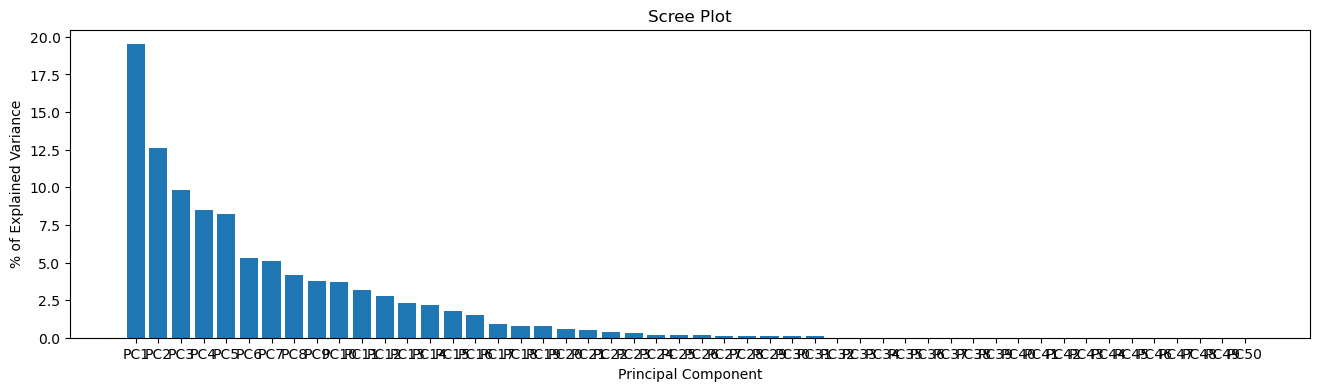

In [106]:
# Scale the input data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform PCA analysis
pca = PCA()
pca.fit(X_train_scaled)
pca_data = pca.transform(X_train_scaled)
pca_data.shape

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' +str(x) for x in range (1,len(per_var) + 1)]

# Plot the explained variance ratio of each variable
plt.figure(figsize=(16,4))
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label = labels)
plt.ylabel('% of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

We see that many variables are not impactful in determining the score, and as a result simple linear regression struggles with some predictions. As a result, we try Lasso and ElasticNet regression. For analyzing the score prediction ability, we use mean absolute error as in the real-world we would care about the aboslute value of how much the error is off directly, not squares of the error. 

In [108]:
lasso_cv = MultiTaskLassoCV(cv=2, random_state=752)
lasso_cv.fit(X_train_scaled, y_train)

ela_net_cv = MultiTaskElasticNetCV(cv=2,random_state=752)
ela_net_cv.fit(X_train_scaled, y_train)

y_pred_lasso = lasso_cv.predict(X_test_scaled)
y_pred_elanet = ela_net_cv.predict(X_test_scaled)

print(f"""MAE are:\nLassoCV:{mean_absolute_error(y_test, y_pred_lasso)},
      \nElasticNetCV:{mean_absolute_error(y_test, y_pred_elanet)} """)


MAE are:
LassoCV:0.012355541794764717,
      
ElasticNetCV:0.34593907848961214 


We see that LassoCV is performing the best, in line with the thinking that perhaps many features in the input are largely irrelevant. We look at a few specific examples: 

In [109]:
for i in range(5):
    print(f"Lasso predicted score: {y_pred_lasso[i]}, real score: {y_test[i]}")
    print(f"ElasticNet predicted score: {y_pred_elanet[i]}, real score: {y_test[i]}")

Lasso predicted score: [2.31961100e-02 5.39824156e+01], real score: [ 0 54]
ElasticNet predicted score: [ 0.46350157 53.37219098], real score: [ 0 54]
Lasso predicted score: [26.99803485 28.00342118], real score: [27 28]
ElasticNet predicted score: [27.27275515 27.26802722], real score: [27 28]
Lasso predicted score: [39.98085166 36.99046712], real score: [40 37]
ElasticNet predicted score: [39.93943856 37.21642134], real score: [40 37]
Lasso predicted score: [13.01072375 42.99090154], real score: [13 43]
ElasticNet predicted score: [12.75603978 42.6659458 ], real score: [13 43]
Lasso predicted score: [44.97600025 32.99348356], real score: [45 33]
ElasticNet predicted score: [44.68786892 33.14489847], real score: [45 33]


In [110]:
# Calculate the residuals
lasso_cv_residuals = y_test - lasso_cv.predict(X_test_scaled)
ela_net_cv_residuals = y_test - ela_net_cv.predict(X_test_scaled)

We now plot residuals:

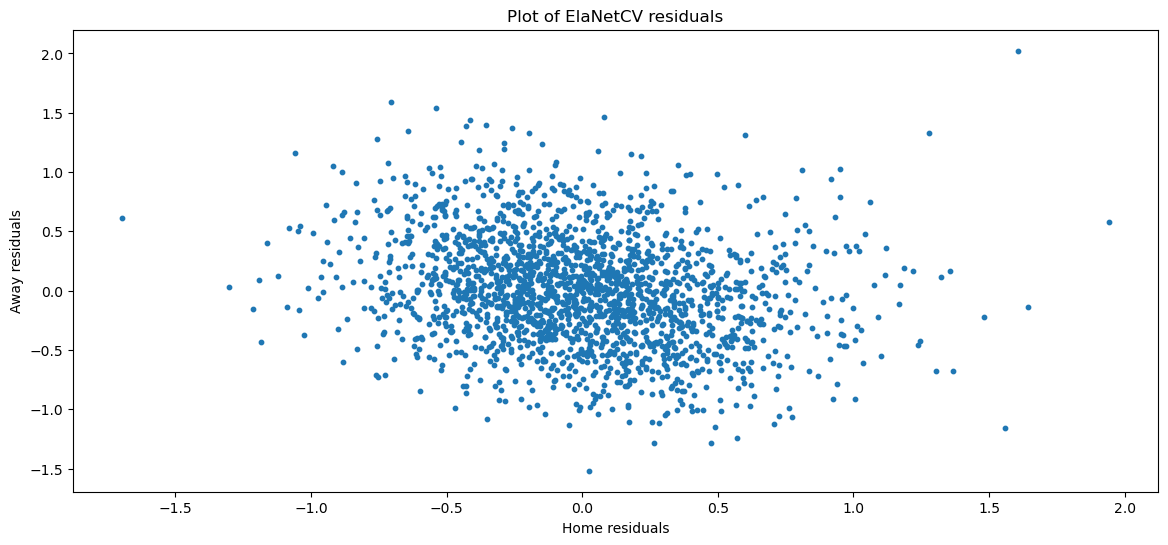

In [112]:
# Plotting residuals
plt.figure(figsize=(14,6))

plt.scatter(x = ela_net_cv_residuals[:,0], y = ela_net_cv_residuals[:,1], s=10)
plt.title('Plot of ElaNetCV residuals')
plt.xlabel('Home residuals')
plt.ylabel('Away residuals')
plt.show()

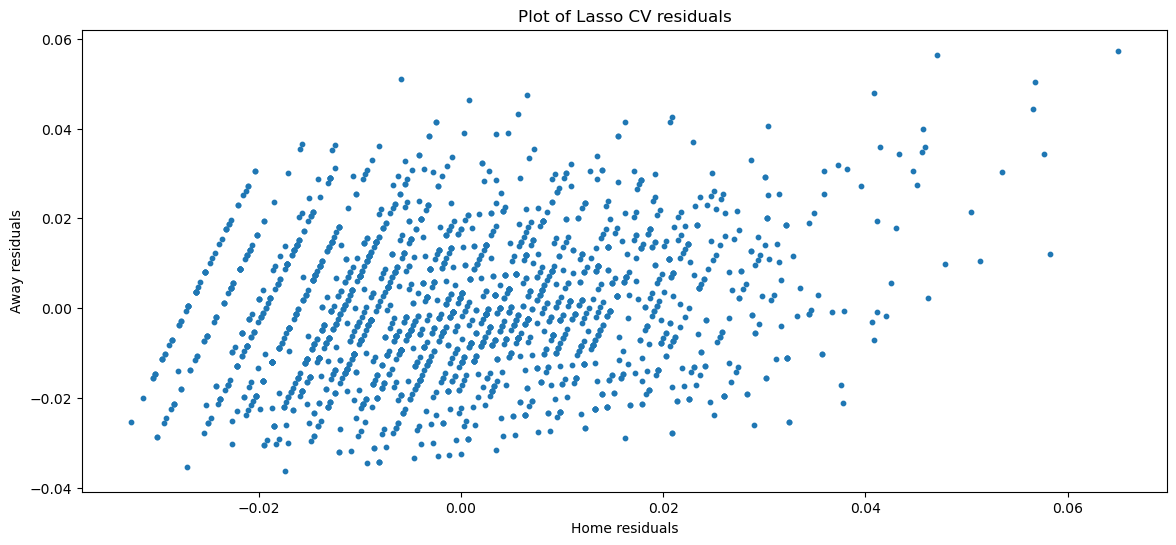

In [113]:
plt.figure(figsize=(14,6))

plt.scatter(x = lasso_cv_residuals[:,0], y = lasso_cv_residuals[:,1], s=10)
plt.title('Plot of Lasso CV residuals')
plt.xlabel('Home residuals')
plt.ylabel('Away residuals')
plt.show()

We now plot the predicted scores against the real scores.

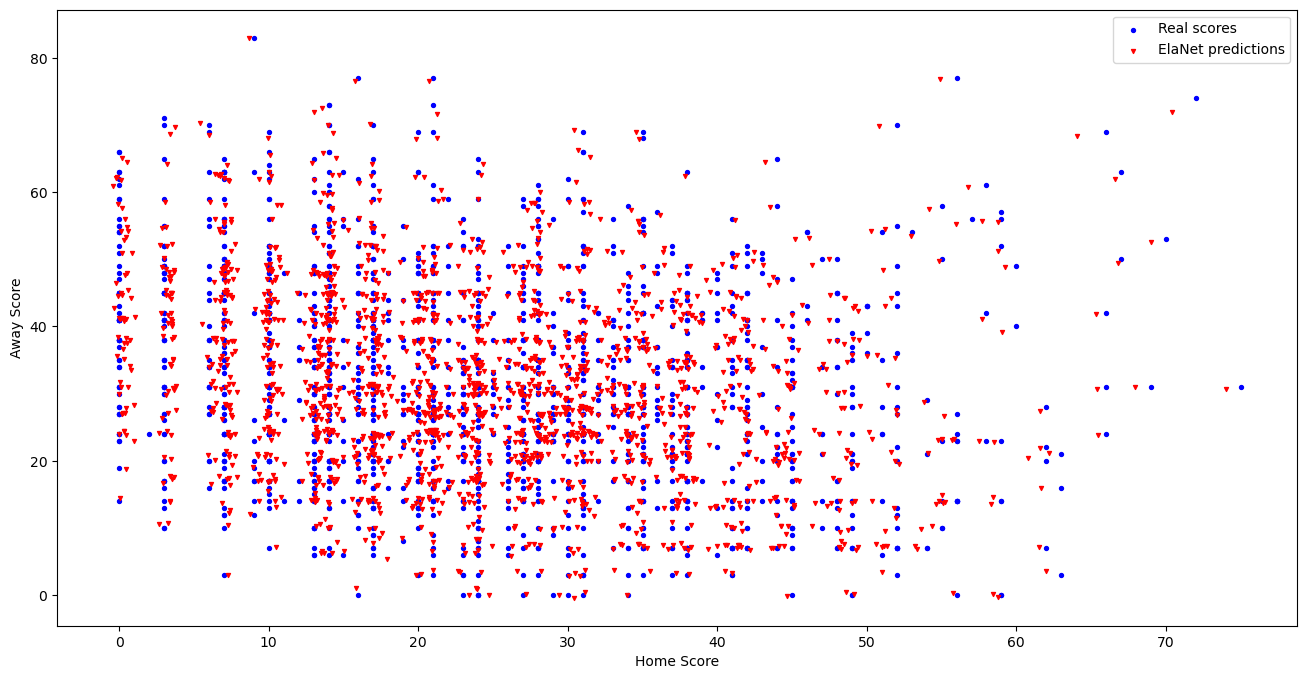

In [114]:
ela_net_cv_predictions = ela_net_cv.predict(X_test_scaled)

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)

ax1.scatter(y_test[:,0], y_test[:,1], s=8, c='b', marker="o", label='Real scores')
ax1.scatter(ela_net_cv_predictions[:,0], ela_net_cv_predictions[:,1], s=8, c='r', marker="v", label='ElaNet predictions')

plt.legend(loc='upper right')
plt.xlabel('Home Score')
plt.ylabel('Away Score')
plt.show()

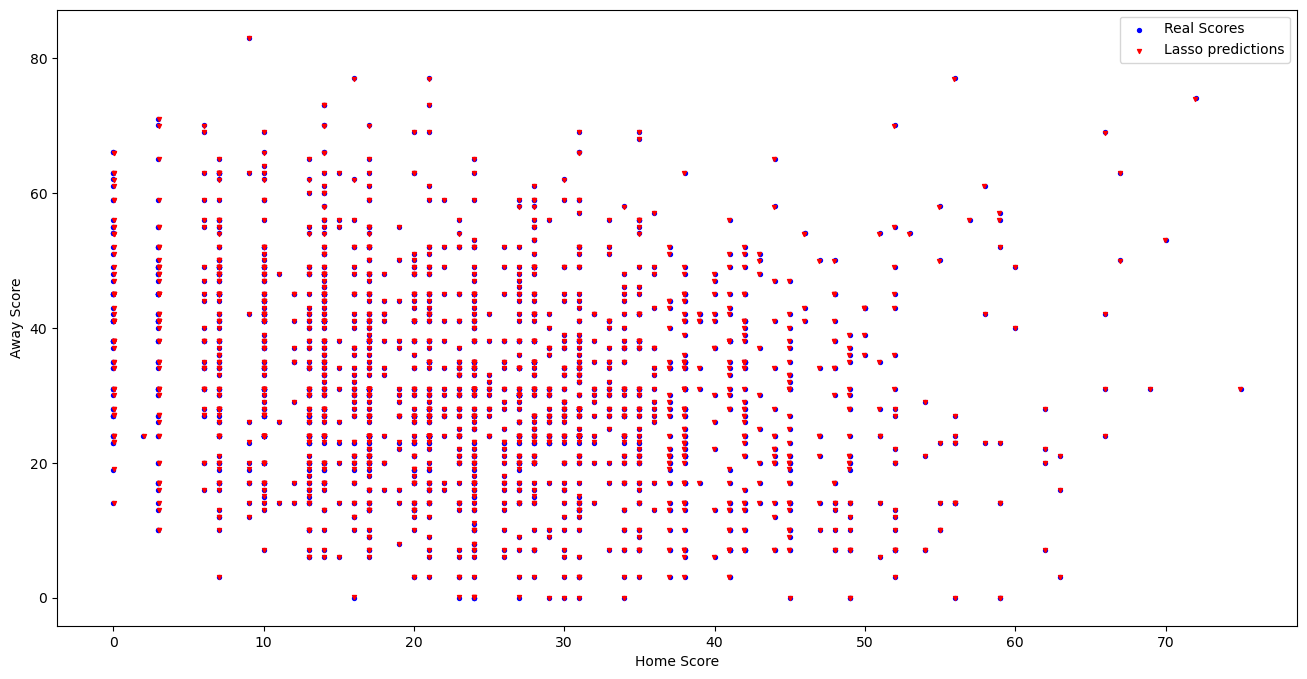

In [115]:
lasso_cv_predictions = lasso_cv.predict(X_test_scaled)

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)

ax1.scatter(y_test[:,0], y_test[:,1], s=8, c='b', marker="o", label='Real Scores')
ax1.scatter(lasso_cv_predictions[:,0], lasso_cv_predictions[:,1], s=8, c='r', marker="v", label='Lasso predictions')

plt.legend(loc='upper right')
plt.xlabel('Home Score')
plt.ylabel('Away Score')
plt.show()

We now plot the predicted scored vs. the residuals

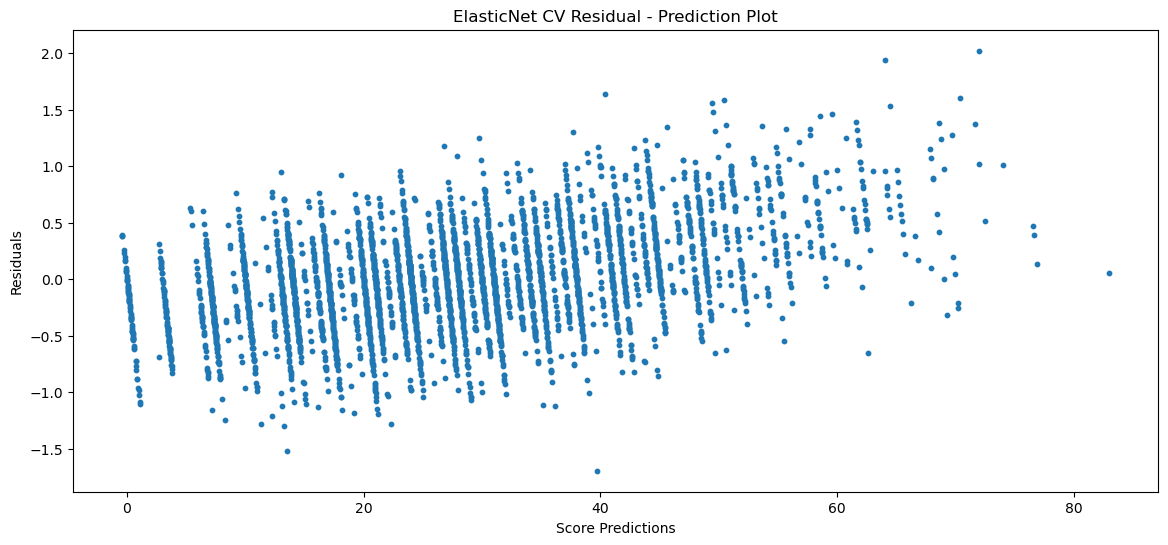

In [116]:
# Visuals of of predicted values vs. residuals
plt.figure(figsize=(14,6))

plt.scatter(x =[ela_net_cv_predictions[:,0], ela_net_cv_predictions[:,1]] ,  y = [ela_net_cv_residuals[:,0], ela_net_cv_residuals[:,1]], s=10)
plt.title('ElasticNet CV Residual - Prediction Plot')
plt.xlabel('Score Predictions')
plt.ylabel('Residuals')
plt.show()


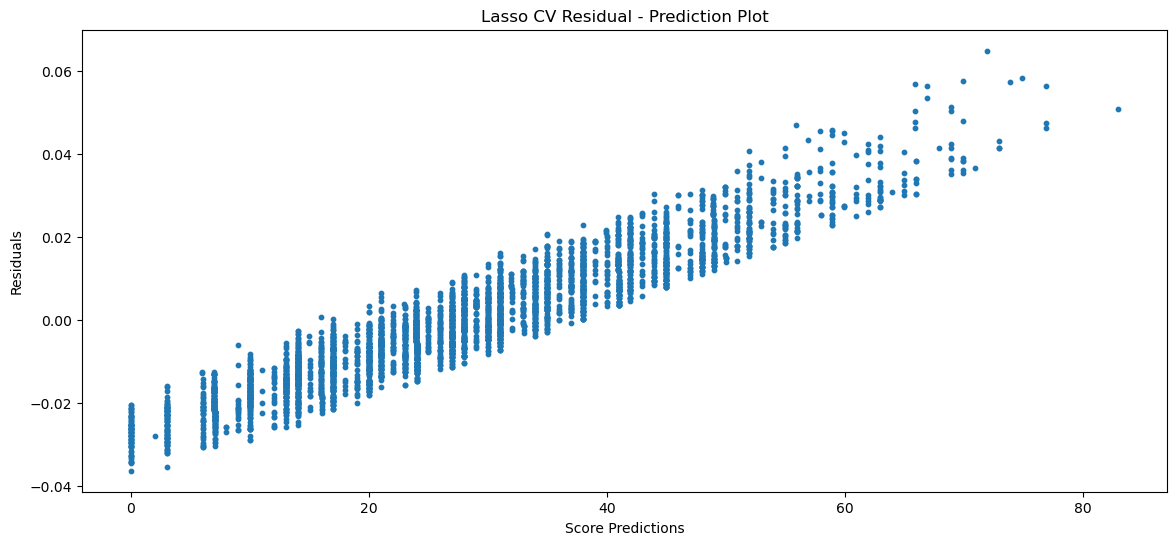

In [117]:
# Visuals of of predicted values vs. residuals
plt.figure(figsize=(14,6))

plt.scatter(x =[lasso_cv_predictions[:,0], lasso_cv_predictions[:,1]] ,  y = [lasso_cv_residuals[:,0], lasso_cv_residuals[:,1]], s=10)
plt.title('Lasso CV Residual - Prediction Plot')
plt.xlabel('Score Predictions')
plt.ylabel('Residuals')
plt.show()

We see an interesting phenomenon where the residuals are the smallest around 30 or so points. As we see, this is roughly the average number of points:

In [118]:
clean_games_df.loc[:, "points"].mean()

28.108483576191652

### Summary of Models 1 and 2
We have generated a model to predict stats from previous games, and we have developed a model to predict the final score from the stats of a given game. We see that in particular, the 